In [ ]:
!pip install -qq transformers

In [ ]:
!pip install watermark

In [3]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.19.4
pandas 1.1.5
torch 1.7.0+cu101
transformers 4.1.1


In [5]:
!gdown --id 1Cv1jgx3CWEko3CFOtqbbR6zm3uI8SxIv

Downloading...
From: https://drive.google.com/uc?id=1Cv1jgx3CWEko3CFOtqbbR6zm3uI8SxIv
To: /content/train.csv
98.6MB [00:02, 35.6MB/s]


In [7]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [10]:
df = pd.read_csv('train.csv')
df.head()
data = df[['title','text','label']]


In [11]:
data.shape

(20800, 3)

In [ ]:
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [25]:
data.shape

(20203, 3)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


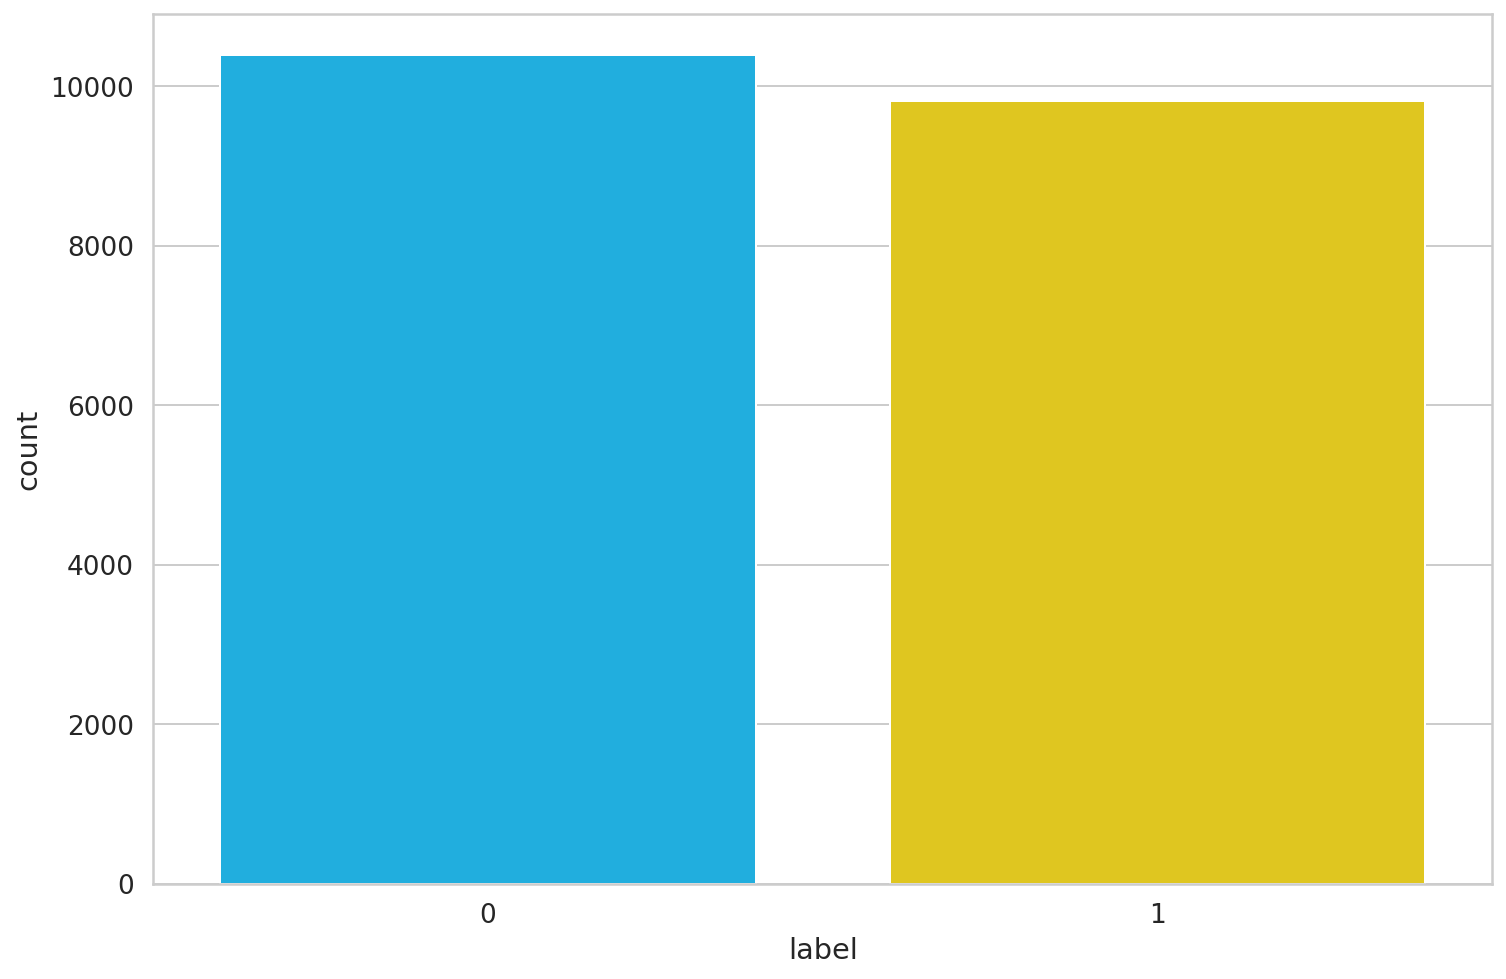

In [26]:
sns.countplot(data.label)

In [27]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [28]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [30]:
token_lens = []

for txt in data.title:
  tokens = tokenizer.encode(txt)
  token_lens.append(len(tokens))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


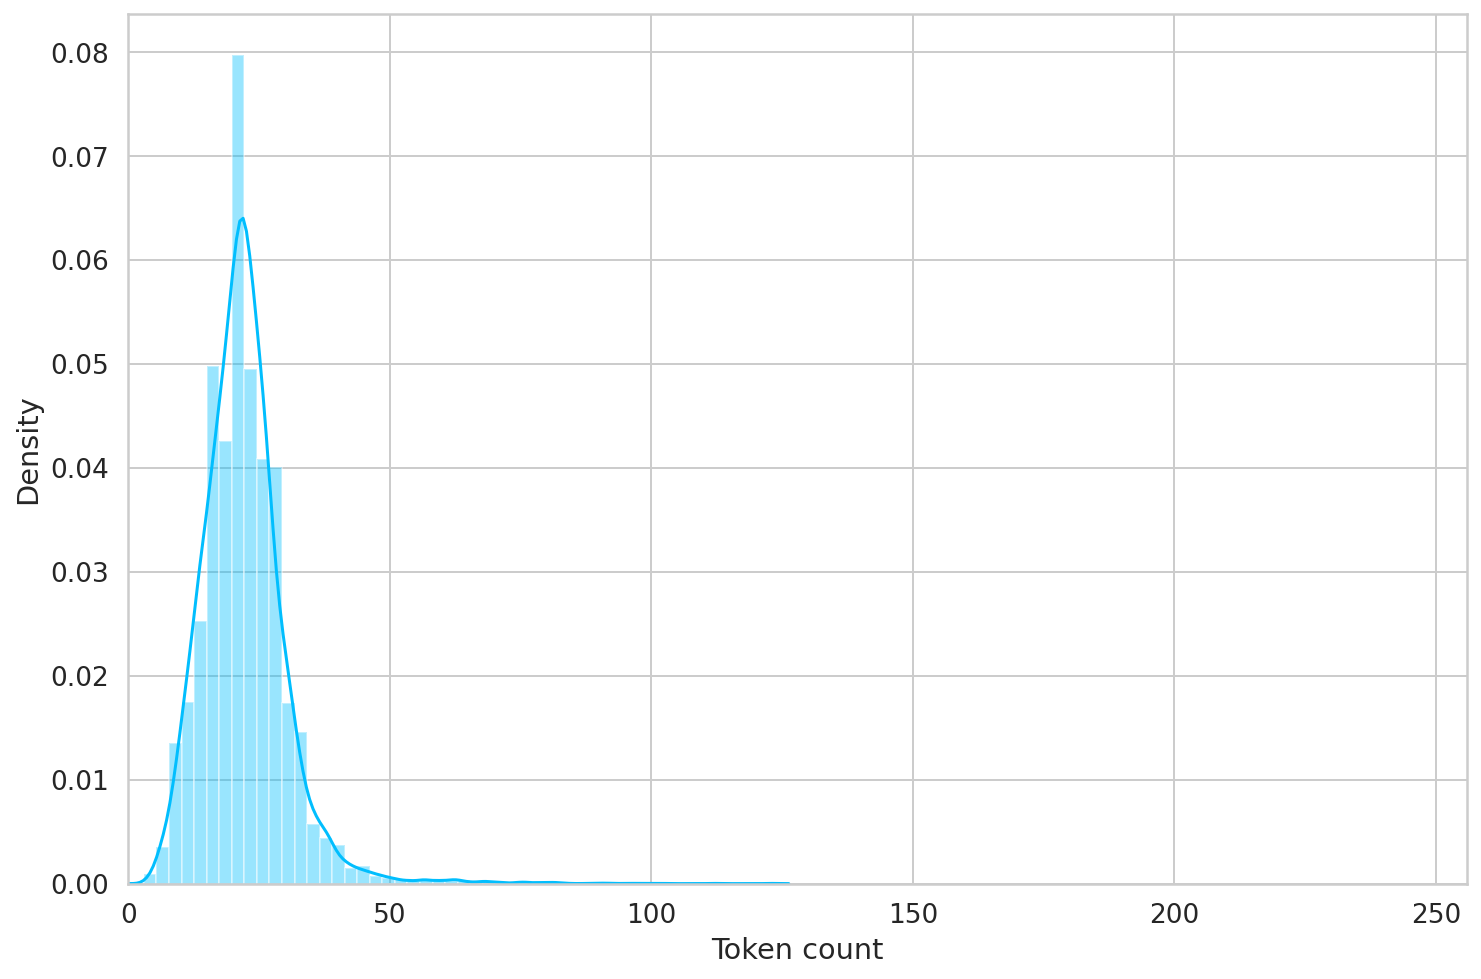

In [31]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [32]:
MAX_LEN = 75

In [43]:
class TrainDataset(Dataset):

  def __init__(self, title, label, tokenizer, max_len):
    self.title = title
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.title)
  
  def __getitem__(self, item):
    review = str(self.title[item])
    target = self.label[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'title': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'label': torch.tensor(target, dtype=torch.long)
    }

In [35]:
train,test = train_test_split(data, test_size=0.1, random_state=RANDOM_SEED)

In [36]:
train.shape, test.shape

((18182, 3), (2021, 3))

In [44]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = TrainDataset(
    title=df.title.to_numpy(),
    label=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [67]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test, tokenizer, MAX_LEN, BATCH_SIZE)

In [46]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

dict_keys(['title', 'input_ids', 'attention_mask', 'label'])

In [48]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['label'].shape)

torch.Size([16, 75])
torch.Size([16, 75])
torch.Size([16])


In [49]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [58]:
class FakeNews(nn.Module):

  def __init__(self, n_classes=2):
    super(FakeNews, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [59]:
model = FakeNews()
model = model.to(device)

In [60]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 75])
torch.Size([16, 75])


In [61]:
import torch.nn.functional as F
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4617, 0.5383],
        [0.3005, 0.6995],
        [0.4775, 0.5225],
        [0.3061, 0.6939],
        [0.3842, 0.6158],
        [0.4302, 0.5698],
        [0.3901, 0.6099],
        [0.3823, 0.6177],
        [0.4397, 0.5603],
        [0.5011, 0.4989],
        [0.2480, 0.7520],
        [0.3369, 0.6631],
        [0.3418, 0.6582],
        [0.3562, 0.6438],
        [0.2485, 0.7515],
        [0.3677, 0.6323]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [62]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [63]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["label"].to(device)
    outputs = model(input_ids=input_ids,attention_mask=attention_mask)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [64]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["label"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [69]:
import warnings
warnings.filterwarnings('ignore')

In [70]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device, 
    len(test)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------
Train loss 0.029273452917300886 accuracy 0.993510064899351
Val   loss 0.1311274202353519 accuracy 0.9708065314200892

Epoch 2/5
----------
Train loss 0.01427668243137919 accuracy 0.9970850291497085
Val   loss 0.1715727281725991 accuracy 0.9668480950024742

Epoch 3/5
----------
Train loss 0.007026424838348451 accuracy 0.9987350126498735
Val   loss 0.19064634378790246 accuracy 0.9693221177634835

Epoch 4/5
----------
Train loss 0.007881727171562915 accuracy 0.998460015399846
Val   loss 0.19064634378790246 accuracy 0.9693221177634835

Epoch 5/5
----------
Train loss 0.00911083850671752 accuracy 0.998350016499835
Val   loss 0.19064634378790246 accuracy 0.9693221177634835

CPU times: user 15min 3s, sys: 7min 51s, total: 22min 55s
Wall time: 23min 9s
